<a href="https://colab.research.google.com/github/yj-shin/yj-shin.github.io/blob/master/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# Load relevant libraries

# numpy 행렬 등 수학적 처리 모듈 
# pandas 데이터 처리 및 조작 모듈
# seaborn: 시각화
# matplotlib : 그래프
# python : 언어
# missingno : 누락된 값을 한눈에 볼 수 있음
# sklearn : ML 알고리즘 라이브러리
# csv 파일을 import하여 dataset이 pandas dataframe이 되도록 한다
# CSV : Comma Separated Values 쉼표로 구분된 값의 약어로 테이블 형식의 데이터를 표현하고 저장하는 일반적인 방법


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from keras.models import Sequential
#from keras.models import Dense
import tensorflow as tf

from google.colab import drive

 # Load relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [73]:
# df = pd.read_csv("/content/drive/MyDrive/test/MiningProcess_Flotation_Plant_Database.csv",decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()

In [74]:
# # Resample data to hourly basis
# df = df.set_index('date').resample('H').first()
# df.shape

In [75]:
filepath = '/content/drive/MyDrive/test/'
filename = 'MiningProcess_Flotation_Plant_Database.csv'
cols_renamed = [
    'date',          # Timestamp of measurements, formatted YYYY-MM-DD HH:MM:SS
    'feed_iron',     # %Iron (valuables) in the ore being fed into the flotation cell
    'feed_silica',   # %Silica (gangue) in the ore being fed into the cell
    'starch_flow',   # Amount of starch (reagent) added into the cell, measured in m^3/h
    'amina_flow',    # Amount of amina (reagent) added into the cell, measured in m^3/h
    'pulp_flow',     # Amount of ore pulp fed into the cell, measured in tonnes/hour
    'pulp_ph',       # Acidity/alkalinity of ore pulp on a scale of 0-14
    'pulp_density',  # Amount of ore in the pulp, between 1-3 kg/cm^3
    'air_col1',      # Volume of air injected into the cell, measured in Nm3/h
    'air_col2',
    'air_col3',
    'air_col4',
    'air_col5',
    'air_col6',
    'air_col7',
    'level_col1',    # Froth height in the cell, measured in mm
    'level_col2',
    'level_col3',
    'level_col4',
    'level_col5',
    'level_col6',
    'level_col7',
    'conc_iron',     # Lab measurement: %Iron in the end of flotation process
    'conc_silica']   # Lab measurement: %Silica in the end of flotation process
df = pd.read_csv(
    filepath+filename,
    header=0,
    names=cols_renamed,
    parse_dates=['date'],
    infer_datetime_format=True,
    decimal=',')
df.head()

,date,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [76]:
# df.isna().sum()

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          737453 non-null  datetime64[ns]
 1   feed_iron     737453 non-null  float64       
 2   feed_silica   737453 non-null  float64       
 3   starch_flow   737453 non-null  float64       
 4   amina_flow    737453 non-null  float64       
 5   pulp_flow     737453 non-null  float64       
 6   pulp_ph       737453 non-null  float64       
 7   pulp_density  737453 non-null  float64       
 8   air_col1      737453 non-null  float64       
 9   air_col2      737453 non-null  float64       
 10  air_col3      737453 non-null  float64       
 11  air_col4      737453 non-null  float64       
 12  air_col5      737453 non-null  float64       
 13  air_col6      737453 non-null  float64       
 14  air_col7      737453 non-null  float64       
 15  level_col1    737

In [78]:
# Resample data to hourly basis
df = df.set_index('date').resample('H').first()
df.shape

(4415, 23)

In [79]:
nans = df[df.isna().any(axis=1)]  # Check for missing values
print(f'Total rows with NaNs: {nans.shape[0]}\n')
nans

Total rows with NaNs: 318



,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-16 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-29 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Remove data with time discontinuity
df = df['2017-03-29 12:00:00':]
df

,feed_iron,feed_silica,starch_flow,amina_flow,pulp_flow,pulp_ph,pulp_density,air_col1,air_col2,air_col3,air_col4,air_col5,air_col6,air_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,conc_iron,conc_silica
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.18,9.34,2044.990000,349.911,405.625000,9.74604,1.649650,200.393,195.734,201.826,295.096,306.400,250.601,251.002,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869,66.44,1.36
2017-03-29 13:00:00,60.18,9.34,2510.360000,306.635,402.303000,9.63786,1.524512,200.165,194.286,201.929,295.096,306.400,250.194,250.188,851.772761,809.863864,881.307250,447.543,421.279,446.697,413.322,66.57,1.43
2017-03-29 14:00:00,60.18,9.34,2138.230000,435.199,401.953000,9.61320,1.594940,199.540,197.436,198.605,295.096,306.400,250.460,250.488,850.510694,774.266870,886.773000,470.638,455.341,457.393,456.480,66.64,1.33
2017-03-29 15:00:00,60.18,9.34,458.079000,476.878,400.173000,9.75149,1.638440,199.951,191.456,199.265,295.096,306.400,247.809,249.582,858.052225,778.343085,883.777182,438.033,446.859,423.184,483.157,66.41,1.27
2017-03-29 16:00:00,59.54,9.56,145.349632,252.088,399.484000,9.96978,1.521080,199.072,182.430,201.251,295.096,306.400,250.488,250.760,853.745107,782.419299,883.715800,435.285,434.663,452.469,436.865,63.63,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,2888.060000,494.990,376.468000,9.27990,1.667860,317.065,297.754,301.685,300.583,300.593,297.551,302.330,577.943000,489.959000,504.995000,440.587,481.295,434.701,401.796,65.05,1.65
2017-09-09 20:00:00,49.75,23.20,4218.570000,492.027,378.630000,9.15799,1.648880,302.081,301.348,300.543,300.125,299.530,336.250,342.615,412.491000,510.388000,342.202000,371.883,594.518,443.687,375.044,64.83,1.71
2017-09-09 21:00:00,49.75,23.20,3159.100000,520.986,381.468667,9.58069,1.736200,296.063,298.480,299.085,299.130,299.588,350.652,332.393,401.456000,533.409000,390.060000,395.463,587.855,489.406,504.982,64.29,1.80


In [81]:
cols = list(df)
cols.insert(0, cols.pop(         # Moving target `conc_silica` to the front
    cols.index('conc_silica')))  # Not necessary but I prefer to do so
df = df.loc[:, cols]
df.to_csv('./Flotation_Dataset_by_Hour.csv')  # For safekeeping

# Drop `conc_iron` then normalize all data
values = df.drop('conc_iron', axis=1).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[0]  # Show first element of the array

array([0.15415822, 0.75694444, 0.25023372, 0.32510961, 0.21746036,
       0.69332766, 0.4831859 , 0.38984084, 0.12485375, 0.09580737,
       0.19501985, 0.14419899, 0.94633739, 0.32903284, 0.31764479,
       0.56808723, 0.55238373, 0.64222035, 0.51514011, 0.48621123,
       0.53465188, 0.59964695])

In [82]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):   # Input sequence (t-n, ... t-1)
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):      # Forecast sequence (t, t+1, ... t+n)
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)  # Put it all together
    agg.columns = names
    if dropnan:                    # Drop rows with NaN values
        agg.dropna(inplace=True)
        
    # Drop columns we don't want to predict
    drop_cols = ['var'+str(i)+'(t)' for i in range(2,23)]
    agg.drop(columns=drop_cols, axis=1, inplace=True)   
    return agg

In [83]:
reframed = series_to_supervised(scaled, n_in=1, n_out=1)
reframed  # Show reframed dataset

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var1(t)
1,0.154158,0.756944,0.250234,0.325110,0.217460,0.693328,0.483186,0.389841,0.124854,0.095807,0.195020,0.144199,0.946337,0.329033,0.317645,0.568087,0.552384,0.642220,0.515140,0.486211,0.534652,0.599647,0.168357
2,0.168357,0.756944,0.250234,0.399114,0.130491,0.614810,0.430529,0.014039,0.123694,0.088174,0.195827,0.144199,0.946337,0.326752,0.313026,0.986143,0.969781,0.992805,0.552195,0.501239,0.532443,0.492095,0.148073
3,0.148073,0.756944,0.250234,0.339937,0.388859,0.606538,0.418525,0.225542,0.120515,0.104780,0.169777,0.144199,0.946337,0.328243,0.314728,0.984364,0.912104,1.000000,0.596969,0.568442,0.552298,0.582143,0.135903
4,0.135903,0.756944,0.250234,0.072755,0.472618,0.564466,0.485839,0.356177,0.122605,0.073255,0.174949,0.144199,0.946337,0.313385,0.309587,0.994997,0.918708,0.996056,0.533758,0.551708,0.488795,0.637805,0.993915
5,0.993915,0.729167,0.257089,0.023025,0.020871,0.548181,0.592093,0.003732,0.118134,0.025672,0.190514,0.144199,0.946337,0.328400,0.316272,0.988924,0.925313,0.995976,0.528430,0.527645,0.543158,0.541217,0.210953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,0.249493,0.304253,0.682144,0.494607,0.513934,0.163464,0.328183,0.396119,0.628798,0.675804,0.938009,0.487274,0.592609,0.614199,0.584263,0.365708,0.488878,0.344877,0.427605,0.573162,0.428127,0.373888,0.212982
3944,0.212982,0.304253,0.682144,0.459176,0.509017,0.004184,0.256289,0.444529,0.718317,0.633630,0.977617,0.586296,0.669616,0.592163,0.608914,0.600062,0.451446,0.497431,0.538709,0.619649,0.510174,0.468046,0.225152
3945,0.225152,0.304253,0.682144,0.670757,0.503062,0.055284,0.196949,0.387530,0.642099,0.652577,0.968668,0.549394,0.618961,0.809050,0.837517,0.366786,0.484547,0.283132,0.405512,0.843034,0.526855,0.412228,0.243408
3946,0.243408,0.304253,0.682144,0.502278,0.561259,0.122377,0.402701,0.649761,0.611488,0.637457,0.957241,0.469225,0.621725,0.889766,0.779511,0.351228,0.521847,0.346131,0.451227,0.829888,0.611724,0.683342,0.275862


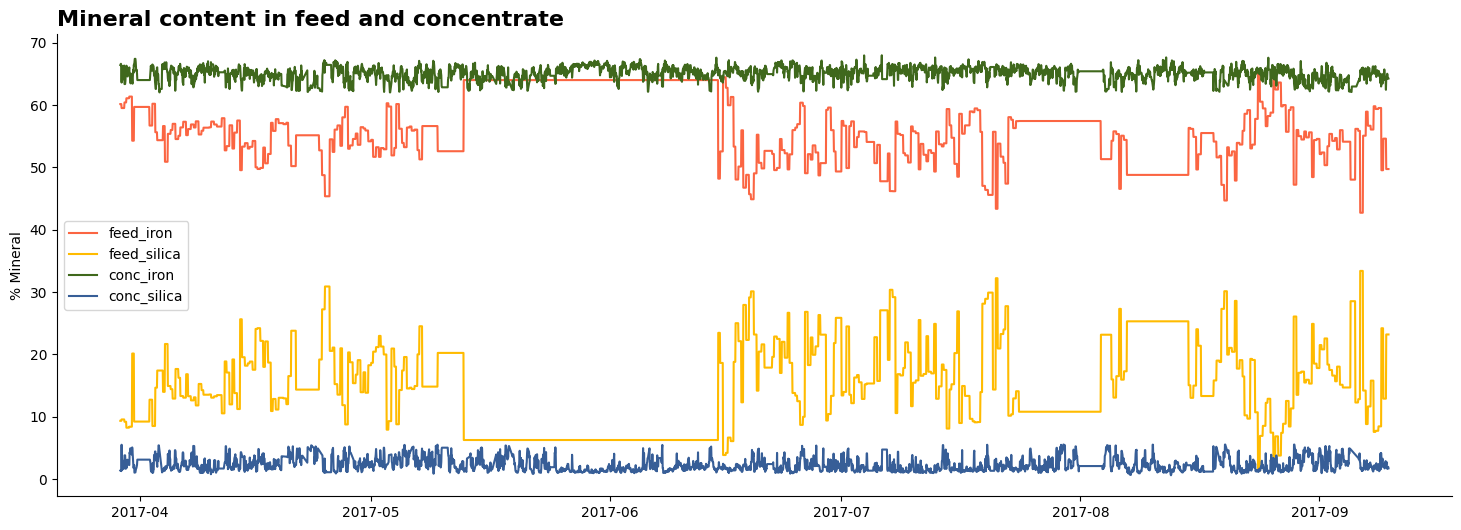

In [84]:
content = ['feed_iron', 'feed_silica', 'conc_iron', 'conc_silica']
palette = ['#FB6542', '#FFBB00', '#3F681C', '#375E97']

# Plot mineral content before and after flotation
plt.style.use('default')
fig, ax = plt.subplots(figsize=(18,6))
for pct, color in zip(content, palette):
    ax.plot(df.index.values, pct, data=df, color=color)
ax.set_title('Mineral content in feed and concentrate',
             loc='left', weight='bold', size=16)
ax.set_ylabel('% Mineral')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center left')
plt.show()

In [85]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# target = '% Silica Concentrate'

# y = df[target]

# X_n = df.drop([target, '% Iron Concentrate'], axis=1) 
# X_i = df.drop(target, axis=1)

# scaler = StandardScaler()

# X_n = scaler.fit_transform(X_n)
# X_i = scaler.fit_transform(X_i)

# X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y, train_size=0.7)
# X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y, train_size=0.7)


# scaler = StandardScaler()   # 객체 만들기
# scaler.fit(x_train)     # 변환 규칙을 익히기
# x_train_scaled = scaler.transform(x_train)  # 데이터를 표준화 전처리
# x_val_scaled = scaler.transform(x_val)      # 데이터를 표준화 전처리

# mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', \
#                     solver='sgd', alpha=0.01, batch_size=32, \
#                     learning_rate_init=0.1, max_iter=500)  # 객체 생성

# mlp.fit(x_train_scaled, y_train)    # 훈련하기
# mlp.score(x_val_scaled, y_val)      # 정확도 평가


n_features = 22             # Number of inputs for forecast
n_hours = 1                 # Number of hours with which to lag features
n_obs = n_hours*n_features

# Define row size of each split
n_train = int(np.round(len(reframed)*.60))
n_valid = int(np.round(len(reframed)*.20))
n_test = int(np.round(len(reframed)*.20))

# Split dataset by row size
values = reframed.values
train = values[:n_train, :]
valid = values[n_train:(n_train+n_valid), :]
test = values[(n_train+n_valid):, :]

# Each set further split into inputs/features (X) and output (y)
train_X, train_y = train[:, :n_obs], train[:, -1]
valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

# Reshape inputs (X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print(  # Show the final shape of each set
    f'Training set  : {train_X.shape}, {train_y.shape}',
    f'\nValidation set: {valid_X.shape}, {valid_y.shape}',
    f'\nTesting set   : {test_X.shape}, {test_y.shape}')

Training set  : (2368, 1, 22), (2368,) 
Validation set: (789, 1, 22), (789,) 
Testing set   : (790, 1, 22), (790,)


In [86]:
from tensorflow.keras.models import Sequential
from keras import models
from keras import layers
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error


model = Sequential()


model.add(Dense(8, input_shape=(train_X.shape[1],
                      train_X.shape[2]),  
          activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(128,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(32,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(16,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(8,  activation="relu"))
model.add(Dense(4, activation="relu"))
# check to see if the regression node should be added

model.add(Dense(1, activation="sigmoid"))
# return our model



model.summary()
# compiling the model
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 1, 8)              184       
_________________________________________________________________
dense_93 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_94 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_95 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_96 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_97 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_98 (Dense)             (None, 1, 8)             

In [87]:
history = model.fit(   # Fit on training data
    train_X,
    train_y,
    epochs=100,
    batch_size=16,
    validation_data=(  # Supply validation data
        valid_X,
        valid_y),
    verbose=2,
    shuffle=False,
    callbacks=ModelCheckpoint(  # Save model
        './LSTM_Flotation_Gangue.hdf5'))

Epoch 1/100
148/148 - 8s - loss: 0.6862 - accuracy: 0.0000e+00 - val_loss: 0.6760 - val_accuracy: 0.0000e+00
Epoch 2/100
148/148 - 2s - loss: 0.6760 - accuracy: 0.0000e+00 - val_loss: 0.6639 - val_accuracy: 0.0000e+00
Epoch 3/100
148/148 - 1s - loss: 0.6690 - accuracy: 0.0000e+00 - val_loss: 0.6549 - val_accuracy: 0.0000e+00
Epoch 4/100
148/148 - 1s - loss: 0.6641 - accuracy: 0.0000e+00 - val_loss: 0.6482 - val_accuracy: 0.0000e+00
Epoch 5/100
148/148 - 1s - loss: 0.6608 - accuracy: 0.0000e+00 - val_loss: 0.6432 - val_accuracy: 0.0000e+00
Epoch 6/100
148/148 - 1s - loss: 0.6585 - accuracy: 0.0000e+00 - val_loss: 0.6395 - val_accuracy: 0.0000e+00
Epoch 7/100
148/148 - 2s - loss: 0.6570 - accuracy: 0.0000e+00 - val_loss: 0.6367 - val_accuracy: 0.0000e+00
Epoch 8/100
148/148 - 2s - loss: 0.6560 - accuracy: 0.0000e+00 - val_loss: 0.6346 - val_accuracy: 0.0000e+00
Epoch 9/100
148/148 - 1s - loss: 0.6554 - accuracy: 0.0000e+00 - val_loss: 0.6330 - val_accuracy: 0.0000e+00
Epoch 10/100
148/14

In [88]:
model.compile(
    loss='mae',        # Mean absolute error
    optimizer='adam')  # Learning rate = 0.001     // optimizer='adam')
model.summary()        # Display model's architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 1, 8)              184       
_________________________________________________________________
dense_93 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_94 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_95 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_96 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_97 (Dense)             (None, 1, 8)              72        
_________________________________________________________________
dense_98 (Dense)             (None, 1, 8)             

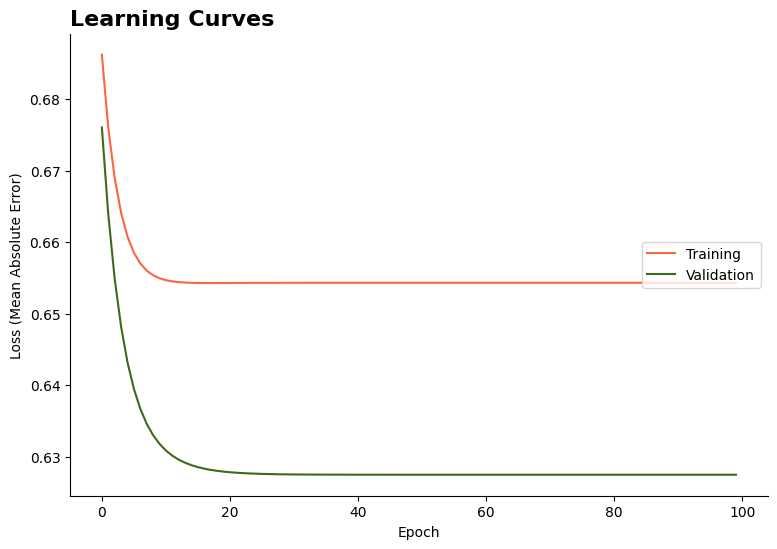

In [89]:
# Extract losses from training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Plot learning curves
#plt.style.use('ggplot')
plt.style.use('default')
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(train_loss, color=palette[0], label='Training')
ax.plot(valid_loss, color=palette[2], label='Validation')
ax.set_title('Learning Curves', loc='left', weight='bold', size=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Mean Absolute Error)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center right')
plt.show()